# Data Analysis Covid-19 in North Carolina Counties

In [84]:
# Dependencies
%matplotlib notebook
from census import Census
from config import (census_key, gkey)
import gmaps
import numpy as np
import pandas as pd
import requests
import time
from us import states
from scipy.stats import linregress
from matplotlib import pyplot as plt
from pprint import pprint

# Census API Key
c = Census(census_key)

## Generate Census Data

In [85]:
census_data = c.acs5.get(("NAME", "B01003_001E","B01002_001E", "B19013_001E","B19301_001E","B07013_002E"),
                         {'for': 'county:*','in': 'state:37'})

census_df = pd.DataFrame(census_data)
census_df

census_df = census_df.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B07013_002E": "Householder Owner",
                                      "NAME": "County"})
census_df


# Add in Householder Owner Rate (Hoseholder Owner / Population)
census_df["Householder Owner Rate"] = 100 * \
    census_df["Householder Owner"].astype(
        int) / census_df["Population"].astype(int)

# Final DataFrame
census_df = census_df[["County", "Population", "Median Age", "Household Income", 
                       "Per Capita Income", "Householder Owner Rate", ]]

census_df["County"]= census_df["County"].str.split(",", n = 1, expand = True)

census_df["Population"] = census_df["Population"].map("{:,.0f}".format)
census_df["Household Income"] = census_df["Household Income"].map("${:,.2f}".format)
census_df["Per Capita Income"] = census_df["Per Capita Income"].map("${:,.2f}".format)
census_df["Householder Owner Rate"] = census_df["Householder Owner Rate"].map("%{:.1f}".format)

census_df['County'] = census_df['County'].str.replace(r'County', '')
census_df

census_df = census_df.sort_values("County", ascending=True)

census_df = census_df.reset_index(drop=True)

# Visualize
print(len(census_df))
census_df.head()

100


,County,Population,Median Age,Household Income,Per Capita Income,Householder Owner Rate
0,Alamance,"157,844",39.7,"$44,281.00","$25,157.00",%64.2
1,Alexander,"37,159",42.8,"$44,523.00","$22,655.00",%71.3
2,Alleghany,"10,935",49.2,"$38,944.00","$21,153.00",%72.8
3,Anson,"25,531",40.4,"$38,123.00","$19,105.00",%60.9
4,Ashe,"26,833",47.2,"$40,293.00","$23,650.00",%73.2


In [86]:
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   County                  100 non-null    object 
 1   Population              100 non-null    object 
 2   Median Age              100 non-null    float64
 3   Household Income        100 non-null    object 
 4   Per Capita Income       100 non-null    object 
 5   Householder Owner Rate  100 non-null    object 
dtypes: float64(1), object(5)
memory usage: 4.8+ KB


In [87]:
# Export to csv
census_df.to_csv("Census.csv", index=False, header=True)

## Generate Covid-19 Data

In [88]:
url="https://api.covid19api.com/dayone/country/united-states"
response = requests.get(url).json()
covid_df = pd.DataFrame(response)
covid_df
covid_df = covid_df.loc[(covid_df["Province"] == "North Carolina")]
covid_df

covid_df = covid_df.rename(columns={"City": "County",
                                    "CityCode": "Zipcode",
                                    "Lat": "Latitude",
                                    "Lon": "Longitude",})
                        
# Final DataFrame
covid_df = covid_df[["County", "Zipcode", "Latitude", "Longitude", "Confirmed", "Deaths", "Recovered", "Active", "Date"]]                                    


Max_date = covid_df["Date"].max()
covid_df = covid_df.loc[(covid_df["Date"] == Max_date)]
covid_df

covid_df = covid_df.sort_values("County", ascending=True)

covid_df = covid_df.reset_index(drop=True)

# Visualize
print(len(covid_df))
covid_df.head()

93


,County,Zipcode,Latitude,Longitude,Confirmed,Deaths,Recovered,Active,Date
0,Alamance,37001,36.04,-79.4,58,0,0,0,2020-04-21T00:00:00Z
1,Alexander,37003,35.92,-81.18,4,0,0,0,2020-04-21T00:00:00Z
2,Alleghany,37005,36.49,-81.13,2,0,0,0,2020-04-21T00:00:00Z
3,Anson,37007,34.97,-80.1,19,0,0,0,2020-04-21T00:00:00Z
4,Ashe,37009,36.43,-81.5,4,0,0,0,2020-04-21T00:00:00Z


In [89]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   County     93 non-null     object
 1   Zipcode    93 non-null     object
 2   Latitude   93 non-null     object
 3   Longitude  93 non-null     object
 4   Confirmed  93 non-null     int64 
 5   Deaths     93 non-null     int64 
 6   Recovered  93 non-null     int64 
 7   Active     93 non-null     int64 
 8   Date       93 non-null     object
dtypes: int64(4), object(5)
memory usage: 6.7+ KB


In [90]:
# Export to csv
covid_df.to_csv("Covid.csv", index=False, header=True)

## Merged Data

In [95]:
# Merge the two data sets along County
merged_df = census_df.merge(covid_df, on="County",how="inner")

merged_data = census_df.update(covid_df)

merged_df.head()

,County,Population,Median Age,Household Income,Per Capita Income,Householder Owner Rate,Zipcode,Latitude,Longitude,Confirmed,Deaths,Recovered,Active,Date
0,Alamance,"157,844",39.7,"$44,281.00","$25,157.00",%64.2,37001,36.04,-79.4,58,0,0,0,2020-04-21T00:00:00Z
1,Alexander,"37,159",42.8,"$44,523.00","$22,655.00",%71.3,37003,35.92,-81.18,4,0,0,0,2020-04-21T00:00:00Z
2,Alleghany,"10,935",49.2,"$38,944.00","$21,153.00",%72.8,37005,36.49,-81.13,2,0,0,0,2020-04-21T00:00:00Z
3,Anson,"25,531",40.4,"$38,123.00","$19,105.00",%60.9,37007,34.97,-80.1,19,0,0,0,2020-04-21T00:00:00Z
4,Ashe,"26,833",47.2,"$40,293.00","$23,650.00",%73.2,37009,36.43,-81.5,4,0,0,0,2020-04-21T00:00:00Z


In [96]:
merged_df.to_csv("Merged_df.csv", index=False, header=True)

## Plotting Data

<IPython.core.display.Javascript object>


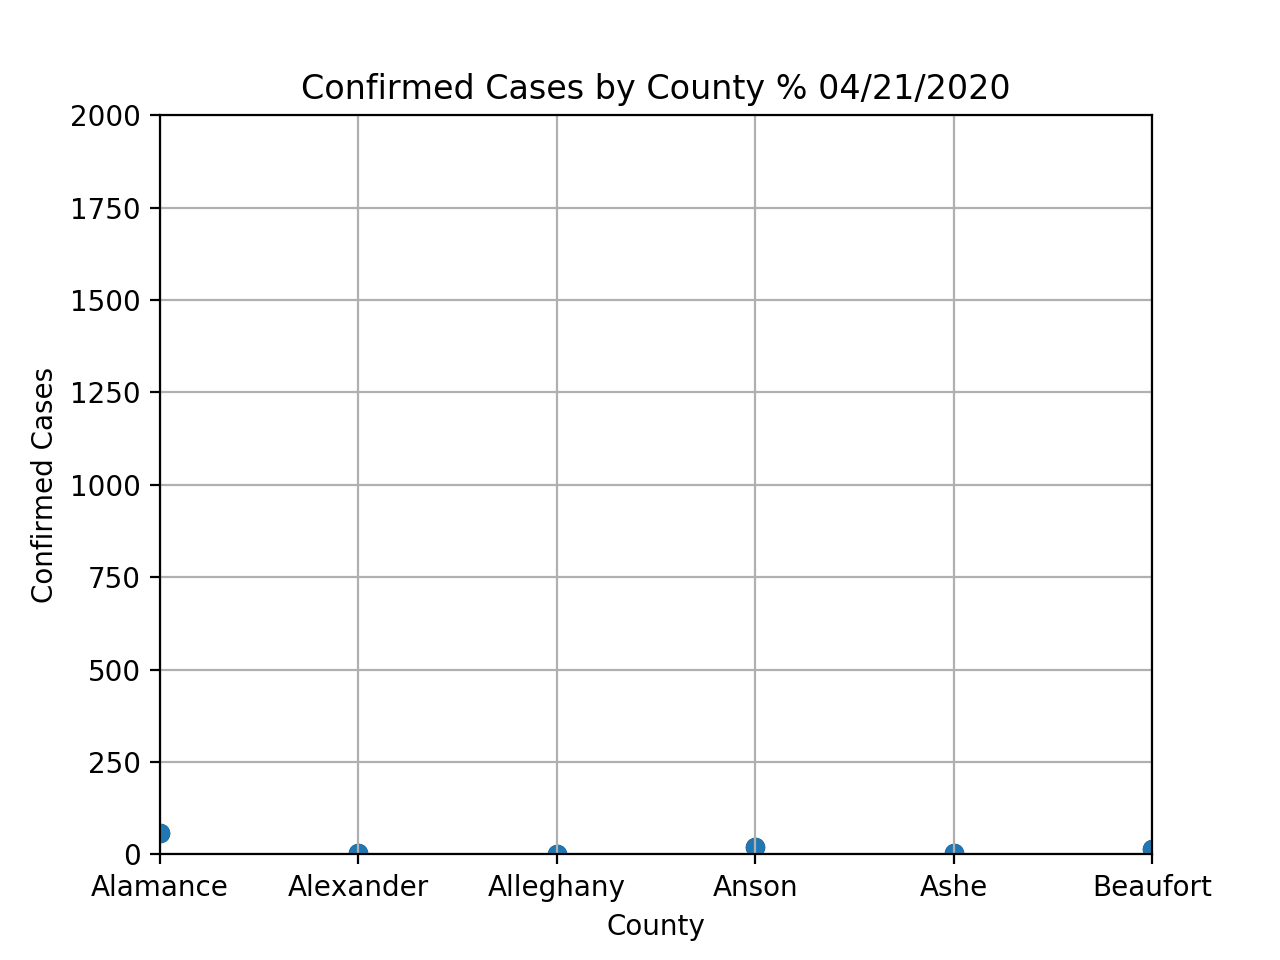

In [115]:
# Build a scatter plot for each data type
plt.scatter(merged_df['County'], merged_df['Confirmed'], marker="o", edgecolors="black", facecolors="aqua")

# Incorporate de other graph properties
plt.title(f'Confirmed Cases by County % {time.strftime("%m/%d/%Y")}')
plt.ylabel("Confirmed")
plt.xlabel("County")
plt.grid(True)
plt.xlim(0,len('Count'))
plt.ylim(0,2000)

# Save the figure
plt.savefig("ConfirmedCasesbyCounty.png")

# Show plot
plt.show()

In [116]:
# Create a Scatter Plot for temperature vs latitude
x_values = merged_df['County']
y_values = merged_df['Confirmed']
plt.scatter(x_values,y_values)
plt.xlabel('County')
plt.ylabel('Confirmed Cases')
plt.show()